# Определение возраста покупателей

**Задача:**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. 

Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построит модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

**Условие:**

*Значение MAE на тестовой выборке должно быть не больше 8.*

**Описание данных:**

Данные о фотографиях находятся в файле `labels.csv`, который содержит  2 столбца: `file_name` и `real_age`. 

## Исследовательский анализ данных

In [3]:
# импортируем необходимые библиотеки и модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# загружаем датасет
labels = pd.read_csv('/datasets/faces/labels.csv')
display(labels.sample(5))

,file_name,real_age
2732,002732.jpg,4
4378,004378.jpg,11
4213,004213.jpg,65
4076,004076.jpg,28
3879,003879.jpg,35


In [3]:
# выведем общую информацию
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
# выведем описательные статистики датасета
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
print('99-й процентиль:',np.percentile (labels.real_age, 99))

99-й процентиль: 82.0


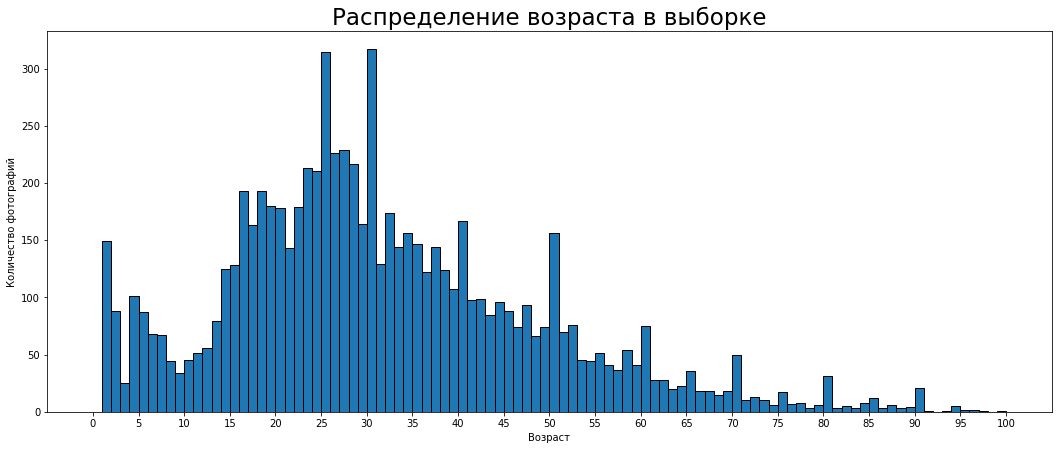

In [5]:
# гистограмма распределения возрастов в датасете
bin_edges = [i for i in range(0, 101, 1)] 

labels.hist(figsize = (18,7),bins=bin_edges, grid=False, edgecolor='black')
plt.xticks(range(0, 101, 5))
plt.title('Распределение возраста в выборке', size=23)
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.show()

Как видно на гистограмме, в датасете превалируют возраста интервала от 15 до 35 лет. Меньше всего фотографий людей верхней границы распределения (75+ лет), что может сказаться на точности предсказания для этой возрастной группы.

In [7]:
# загрузим фотографии
datagen = ImageDataGenerator()
images = datagen.flow_from_dataframe(dataframe=labels,
                                     directory='/datasets/faces/final_files',
                                     batch_size=16,
                                     x_col='file_name',
                                     y_col='real_age',
                                     class_mode='raw',
                                     seed=1234)

Found 7591 validated image filenames.


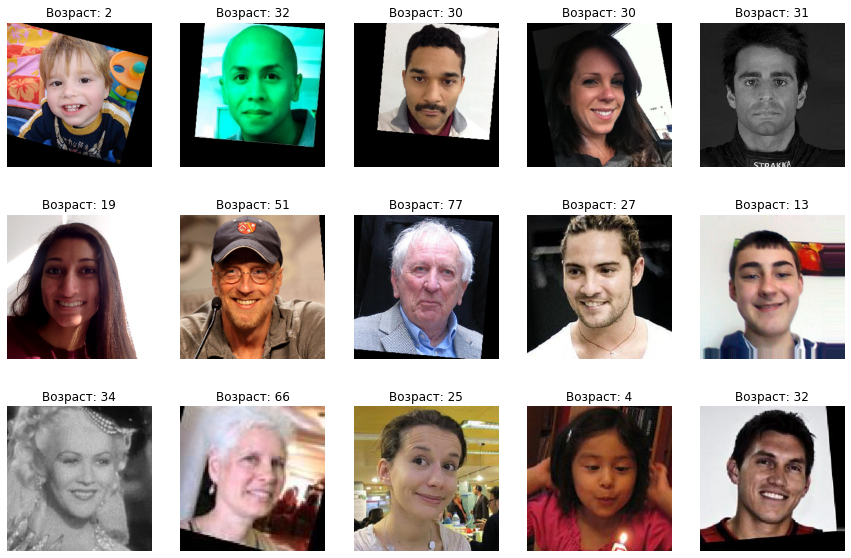

In [8]:
# выведем 15 фотографий 
plt.figure(figsize=(15, 10))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    img,lab=images.next()
    plt.imshow(img[i].astype("uint8"))
    plt.title('Возраст: ' + str(lab[i]))
    plt.axis("off")

plt.show()

### Вывод

- Для обучения и проверки сверточной нейронной сети нам доступен датасет из 7591 фотографии.
- Средний возраст выборки составляет 31 год, нижняя граница - 1 год, верхняя - 100 лет.
- Меньше всего в выборке людей пожилого возраста (99-й процентиль равен 82 годам).
- В изначальном датасете присутствуют трансформированные фотографии. На рандомной выборке видно, что есть черно-белые и цветные фото, изображения с разными углами наклона. Следовательно, дополнительной аугментации не требуется, возможно стоит только отобразить фото по вертикали и горизонтали.

## Обучение модели

**NB!** Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

Построим сверточную нейронную сеть на основе архитектуры **ResNet50** с весами **ImageNet**. Разделим данные на тренировочную и тестовую выборки в соотношении 75/25 соответственно. В изначальном датасете присутствуют различные варианты трансформации фотографий, поэтому для аугментации воспользуемся только параметрами `vertical_flip` и `horizontal_flip` метода **ImageDataGenerator**. 

В качестве функции потерь используем *MSE*, так с ней нейронные сети зачастую обучаются быстрее, для оценки точности модели возьмем *MAE*. 

```python

# загружаем необходимые библиотеки и модули
import pandas as pd
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# формируем тренировочную выборку 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25, vertical_flip=True, horizontal_flip = True)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(150, 150),
        batch_size=16,
        subset='training',
        seed=12345
    )

    return train_datagen_flow

# формируем тестовую выборку 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        target_size=(150, 150),
        batch_size=16,
        subset='validation',
        seed=12345
    )

    return test_datagen_flow

# создаем модель на основе архитектуры ResNet50
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])

    return model

# обучаем модель
def train_model(model, train_data, test_data,
                batch_size=None,epochs=10,steps_per_epoch= None,
                validation_steps= None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              shuffle=True,
              verbose=2)

    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 67s - loss: 261.1425 - mae: 11.8628 - val_loss: 414.9099 - val_mae: 15.3565
Epoch 2/10
356/356 - 36s - loss: 120.4925 - mae: 8.3604 - val_loss: 200.0946 - val_mae: 10.7303
Epoch 3/10
356/356 - 36s - loss: 95.0650 - mae: 7.4447 - val_loss: 102.2738 - val_mae: 7.5417
Epoch 4/10
356/356 - 37s - loss: 77.8556 - mae: 6.7316 - val_loss: 98.5598 - val_mae: 7.5277
Epoch 5/10
356/356 - 37s - loss: 64.9462 - mae: 6.1753 - val_loss: 114.9840 - val_mae: 7.7110
Epoch 6/10
356/356 - 37s - loss: 56.0258 - mae: 5.7656 - val_loss: 121.7127 - val_mae: 8.2676
Epoch 7/10
356/356 - 36s - loss: 46.5424 - mae: 5.2043 - val_loss: 92.1583 - val_mae: 7.2165
Epoch 8/10
356/356 - 36s - loss: 39.8233 - mae: 4.8221 - val_loss: 90.7241 - val_mae: 7.2649
Epoch 9/10
356/356 - 36s - loss: 33.2520 - mae: 4.4135 - val_loss: 86.7768 - val_mae: 7.0874
Epoch 10/10
356/356 - 36s - loss: 34.0261 - mae: 4.4635 - val_loss: 77.6761 - val_mae: 6.5645

119/119 - 9s - loss: 77.6761 - mae: 6.5645
Test MAE: 6.5645
```

## Анализ обученной модели

В среднем модель ошибается на **6.5 лет**, что является допустимым зачением в соответствии с условием задачи. Можно также заметить, что нейросеть склонна к переобучению - на тренировочных данных ошибка от эпохи к эпохе уменьшается достаточно быстро, тогда как на тестовой выборке качество растет медленнее.

Исходя из рассмотренных результатов, нейронную сеть можно использовать в качестве протипа для рекомендательной системы товаров, так как расхождения в 6.5 лет допустимы для категоризации покупателей и поиска релевантных товаров. Для задачи контроля продавцов при продаже алкоголя качество нейронной сети стоит улучшить, так как ошибка достаточно велика. Возможно, стоит добавить в выборку больше фотографий "пограничного" возраста - 15-20 лет.